In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from datetime import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


%matplotlib inline  
series=yf.download('BTC-USD',start='2020-01-21', interval='1h',  end='2021-01-21',progress=False)[['Close']]
series.head()


,Close
Date,
2020-01-21,8660.563477
2020-01-21,8657.198242
2020-01-21,8633.509766
2020-01-21,8649.244141
2020-01-21,8638.959961


                  Close
Date                   
2020-01-21  8660.563477
2020-01-21  8657.198242
2020-01-21  8633.509766
2020-01-21  8649.244141
2020-01-21  8638.959961


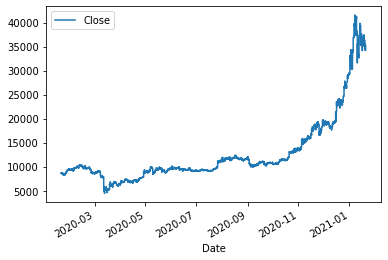

In [3]:
print(series.head())
series.plot()
plt.show()

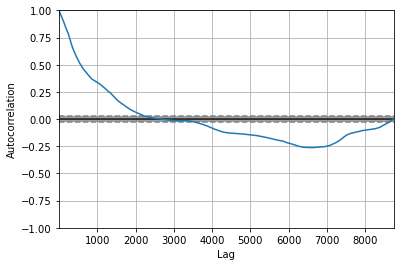

In [4]:
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot
 
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
 
series = yf.download('BTC-USD',start='2020-01-21', interval='1h',  end='2021-01-21',progress=False)[['Close']]
autocorrelation_plot(series)
pyplot.show()

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 8743
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -55155.679
Date:                Sun, 24 Jan 2021   AIC                         110323.357
Time:                        08:59:45   BIC                         110365.813
Sample:                    01-31-2020   HQIC                        110337.825
                         - 01-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0452      0.003     14.131      0.000       0.039       0.051
ar.L2         -0.0437      0.003    -14.881      0.000      -0.049      -0.038
ar.L3          0.0178      0.003      5.492      0.0

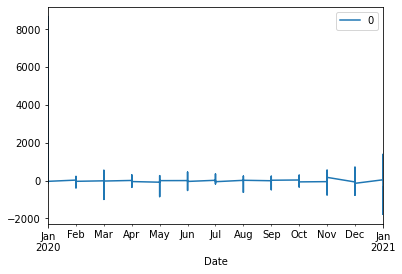

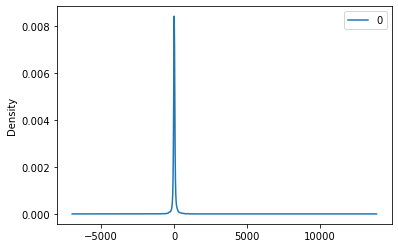

                 0
count  8743.000000
mean      4.040672
std     162.024888
min   -1779.935528
25%     -20.912605
50%       1.552966
75%      25.996666
max    8660.563477


In [6]:
# fit an ARIMA model and plot residual errors

from pandas import DataFrame
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot
# load dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
series = yf.download('BTC-USD',start='2020-01-21', interval='1h',  end='2021-01-21',progress=False)[['Close']]
series.index = series.index.to_period('M')
# fit model
model = ARIMA(series, order=(5,1,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

In [9]:
# Rolling Forecast ARIMA Model
# evaluate an ARIMA model using a walk-forward validation

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
# load dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
series = yf.download('BTC-USD',start='2020-01-21', interval='1d',  end='2021-01-21',progress=False)[['Close']]
series.index = series.index.to_period('M')
# split into train and test sets
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes


predicted=10929.062513, expected=10948.990234
predicted=10972.682917, expected=10944.585938
predicted=10969.943997, expected=11094.346680
predicted=11105.980933, expected=10938.271484
predicted=10980.075801, expected=10462.259766
predicted=10484.062178, expected=10538.459961
predicted=10522.220081, expected=10225.864258
predicted=10303.433615, expected=10745.548828
predicted=10609.773310, expected=10702.290039
predicted=10735.868276, expected=10754.437500
predicted=10683.206614, expected=10774.426758
predicted=10789.431413, expected=10721.327148
predicted=10768.167743, expected=10848.830078
predicted=10829.271549, expected=10787.618164
predicted=10814.690844, expected=10623.330078
predicted=10623.008341, expected=10585.164062
predicted=10586.476842, expected=10565.493164
predicted=10586.552031, expected=10684.428711
predicted=10656.398023, expected=10804.000977
predicted=10784.254122, expected=10621.664062
predicted=10634.348117, expected=10679.136719
predicted=10655.392330, expected=1

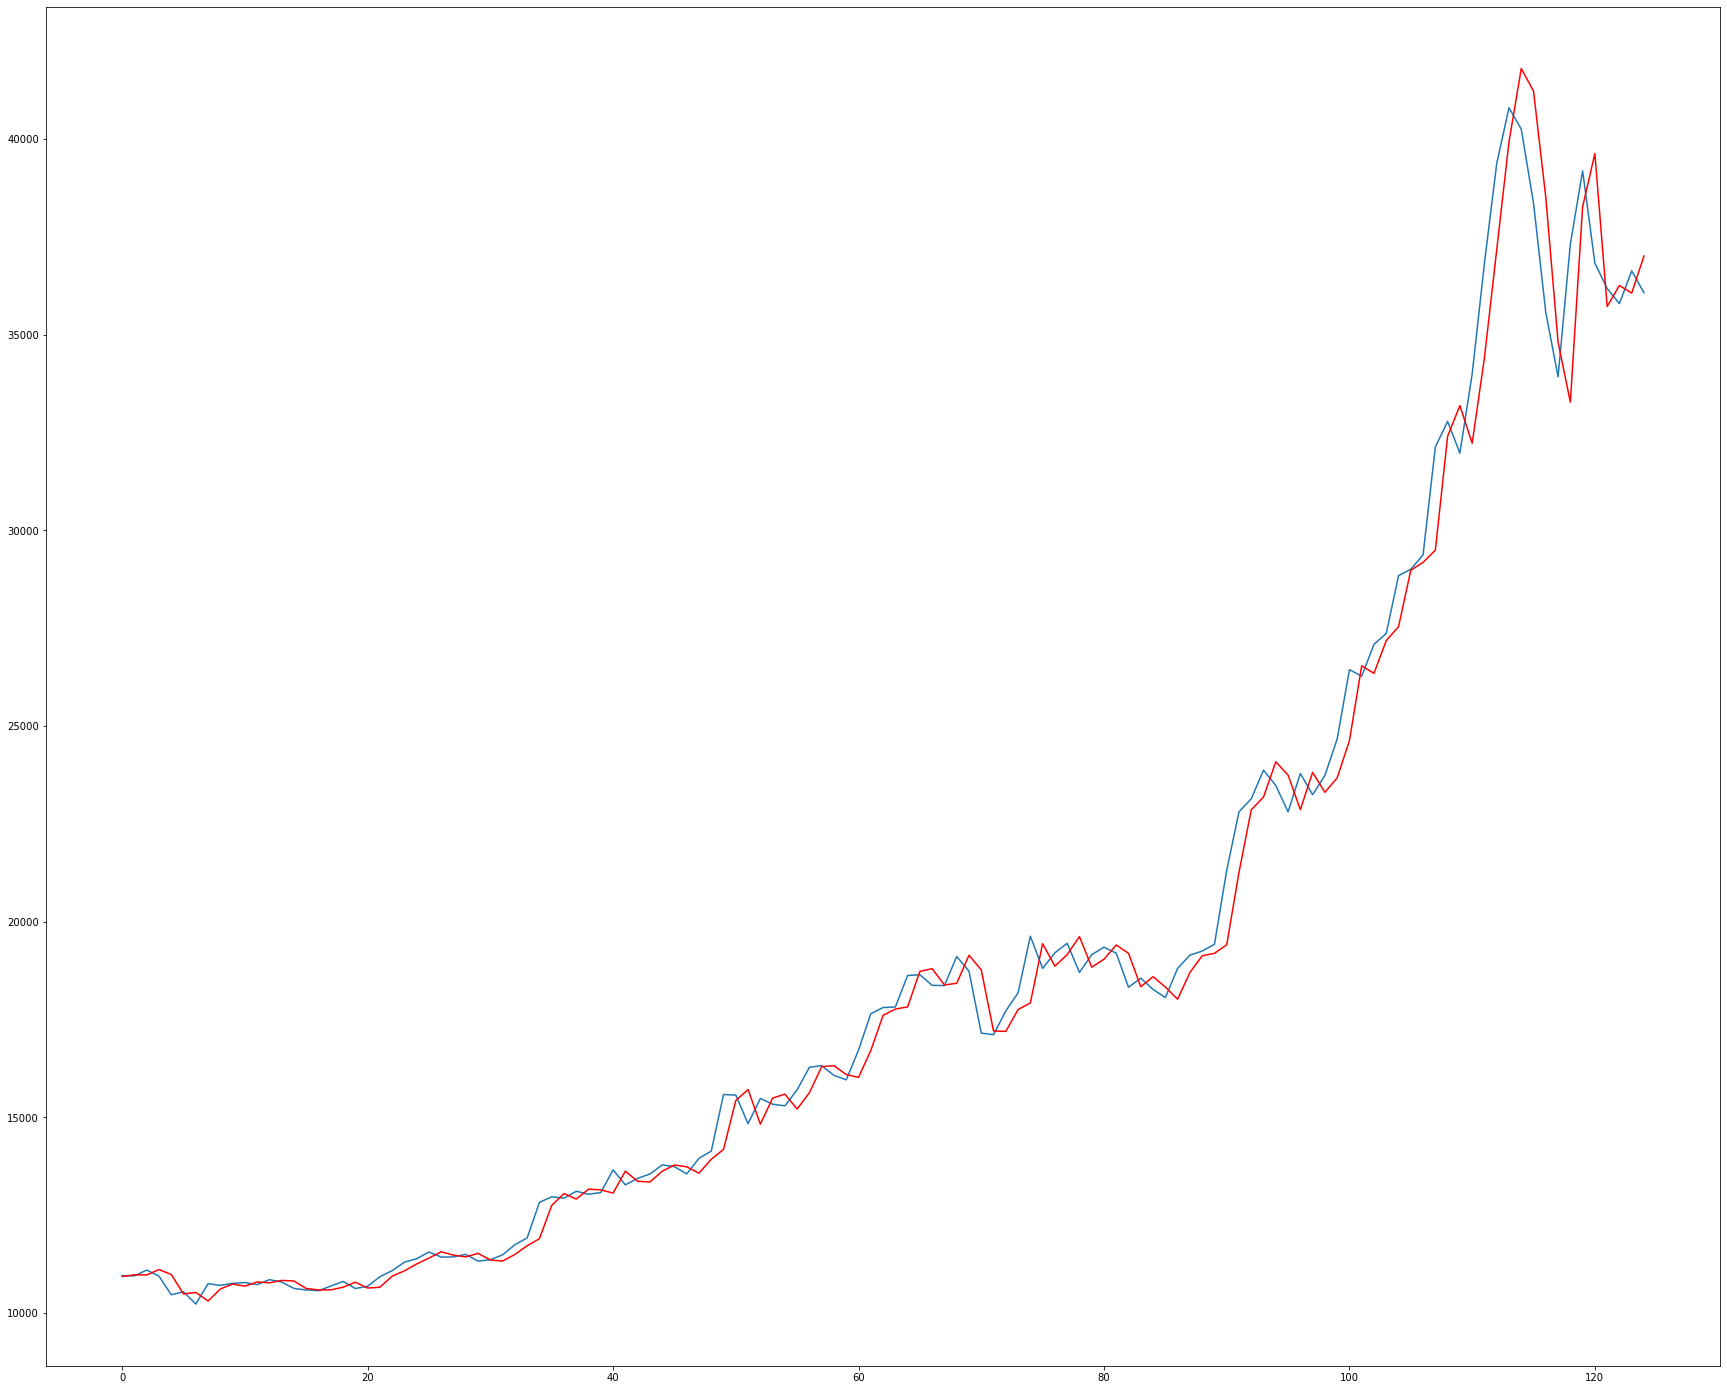

In [10]:

fig= plt.figure(figsize=(30,25))
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()